## Test tensor calculations by calculating schwarzschild symbols

In [140]:
# from FANTASY import *
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

#### Modify code to calculate Schwarzschild metric

In [141]:
# Copyright (C) 2020 Pierre Christian and Chi-kwan Chan
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
# General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

'''
################### USER GUIDE ###################
FANTASY is a geodesic integration code for arbitrary metrics with automatic differentiation. Please refer to Christian and Chan, 2021 for details.

################### Inputing the Metric ###################
Components of the metric are stored in the functions g00, g01, g02, etc that can be found under the heading "Metric Components". Each of these take as input a list called Param, which contains the fixed parameters of the metric (e.g., 'M' and 'a' for the Kerr metric in Boyer-Lindquist coordinates) and a list called Coord, which contains the coordinates (e.g., 'r' and 't' for the Kerr metric in Boyer-Lindquist coordinates). In order to set up a metric,
Step 1) Write down the fixed parameters in a list
Step 2) Write down the coordinates in a list
Step 3) Type the metric into the functions under "Metric Components".

Example: Kerr in Boyer-Lindquist coordinates
Step 1) The fixed parameters are listed as [M,a]
Step 2) The coordinates are listed as [t,r,theta,phi]
Step 3) Type in the metric components, for example, the g11 function becomes:

def g11(Param,Coord):
    return (Param[1]**2.-2.*Param[0]*Coord[1]+Coord[1]**2.)/(Coord[1]**2.+Param[1]**2.*cos(Coord[2])**2.)

Extra step) To make your code more readable, you can redefine variables in place of Param[i] or Coord[i], for example, the g11 function can be rewritten as:
def g11(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    return (a**2.-2.*M*r+r**2.)/(r**2.+a**2.*cos(theta)**2.)

################### A Guide on Choosing omega ###################
The parameter omega determines how much the two phase spaces interact with each other. The smaller omega is, the smaller the integration error, but if omega is too small, the equation of motion will become non-integrable. Thus, it is important to find an omega that is appropriate for the problem at hand. The easiest way to choose an omega is through trial and error:

Step 1) Start with omega=1; if you are working in geometric/code units in which all relevant factors are ~unity, this is usually already a good choice of omega
Step 2) If the trajectory varies wildly with time (this indicates highly chaotic, non-integrable behavior), increase omega and redo integration
Step 3) Repeat Step 2) until trajectory converges

################### Running the Code ###################
To run the code, run the function geodesic_integrator(N,delta,omega,q0,p0,Param,order). N is the number of steps, delta is the timestep, omega is the interaction parameter between the two phase spaces, q0 is a list containing the initial position, p0 is a list containing the initial momentum, Param is a list containing the fixed parameters of the metric (e.g., [M,a] for Kerr metric in Boyer-Lindquist coordinates), and order is the integration order. You can choose either order=2 for a 2nd order scheme or order=4 for a 4th order scheme.

################### Reading the Output ###################
The output is a numpy array indexed by timestep. For each timestep, the output contains four lists:

output[timestep][0] = a list containing the position of the particle at said timestep in the 1st phase space
output[timestep][1] = a list containing the momentum of the particle at said timestep in the 1st phase space
output[timestep][2] = a list containing the position of the particle at said timestep in the 2nd phase space
output[timestep][3] = a list containing the momentum of the particle at said timestep in the 2nd phase space

As long as the equation of motion is integrable (see section "A Guide on Choosing omega"), the trajectories in the two phase spaces will quickly converge, and you can choose either one as the result of your calculation.

################### Automatic Jacobian ###################

Input coordinate transformations for the 0th, 1st, 2nd, 3rd coordinate in functions CoordTrans0, CoordTrans1, CoordTrans2, CoordTrans3. As an example, coordinate transformation from Spherical Schwarzschild to Cartesian Schwarzschild has been provided.

'''

################### Code Preamble ###################

from pylab import *
from scipy import special
import numpy
from IPython.display import clear_output, display

class dual:
  def __init__(self, first, second):
    self.f = first
    self.s = second

  def __mul__(self,other):
    if isinstance(other,dual):
      return dual(self.f*other.f, self.s*other.f+self.f*other.s)
    else:
      return dual(self.f*other, self.s*other)

  def __rmul__(self,other):
    if isinstance(other,dual):
      return dual(self.f*other.f, self.s*other.f+self.f*other.s)
    else:
      return dual(self.f*other, self.s*other)

  def __add__(self,other):
    if isinstance(other,dual):
      return dual(self.f+other.f, self.s+other.s)
    else:
      return dual(self.f+other,self.s)

  def __radd__(self,other):
    if isinstance(other,dual):
      return dual(self.f+other.f, self.s+other.s)
    else:
      return dual(self.f+other,self.s)

  def __sub__(self,other):
    if isinstance(other,dual):
      return dual(self.f-other.f, self.s-other.s)
    else:
      return dual(self.f-other,self.s)

  def __rsub__(self, other):
    return dual(other, 0) - self

  def __truediv__(self,other):
    ''' when the first component of the divisor is not 0 '''
    if isinstance(other,dual):
      return dual(self.f/other.f, (self.s*other.f-self.f*other.s)/(other.f**2.))
    else:
      return dual(self.f/other, self.s/other)

  def __rtruediv__(self, other):
    return dual(other, 0).__truediv__(self)

  def __neg__(self):
      return dual(-self.f, -self.s)

  def __pow__(self, power):
    return dual(self.f**power,self.s * power * self.f**(power - 1))

  def sin(self):
    return dual(numpy.sin(self.f),self.s*numpy.cos(self.f))

  def cos(self):
    return dual(numpy.cos(self.f),-self.s*numpy.sin(self.f))

  def tan(self):
    return sin(self)/cos(self)

  def log(self):
    return dual(numpy.log(self.f),self.s/self.f)

  def exp(self):
    return dual(numpy.exp(self.f),self.s*numpy.exp(self.f))

def dif(func,x):
    funcdual = func(dual(x,1.))
    if isinstance(funcdual,dual):
        return func(dual(x,1.)).s
    else:
        ''' this is for when the function is a constant, e.g. gtt:=0 '''
        return 0

################### Metric Components ###################

# Diagonal components of the metric
def g00(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    Delta = r**2.-2.*M*r+a**2.
    rhosq = r**2.+a**2.*cos(theta)**2.
    return -(r**2.+a**2.+2.*M*r*a**2.*sin(theta)**2./rhosq)/Delta
def g11(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    return (a**2.-2.*M*r+r**2.)/(r**2.+a**2.*cos(theta)**2.)
def g22(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    return 1./(r**2.+a**2.*cos(theta)**2.)
def g33(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    Delta = r**2.-2.*M*r+a**2.
    rhosq = r**2.+a**2.*cos(theta)**2.
    return (1./(Delta*sin(theta)**2.))*(1.-2.*M*r/rhosq)

# Off-diagonal components of the metric
def g01(Param,Coord):
    return 0
def g02(Param,Coord):
    return 0
def g03(Param,Coord):
    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    Delta = r**2.-2.*M*r+a**2.
    rhosq = r**2.+a**2.*cos(theta)**2.
    return -(2.*M*r*a)/(rhosq*Delta)
def g12(Param,Coord):
    return 0
def g13(Param,Coord):
    return 0
def g23(Param,Coord):
    return 0

################### Metric Derivatives ###################

def dm(Param,Coord,metric,wrt):
    ''' wrt = 0,1,2,3 '''
    point_d = Coord[wrt]

    point_0 = dual(Coord[0],0)
    point_1 = dual(Coord[1],0)
    point_2 = dual(Coord[2],0)
    point_3 = dual(Coord[3],0)

    if metric == 'g00':
        if wrt == 0:
            return dif(lambda p:g00(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:g00(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:g00(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:g00(Param,[point_0,point_1,point_2,p]),point_d)
    elif metric == 'g11':
        if wrt == 0:
            return dif(lambda p:g11(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:g11(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:g11(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:g11(Param,[point_0,point_1,point_2,p]),point_d)
    elif metric == 'g22':
        if wrt == 0:
            return dif(lambda p:g22(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:g22(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:g22(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:g22(Param,[point_0,point_1,point_2,p]),point_d)
    elif metric == 'g33':
        if wrt == 0:
            return dif(lambda p:g33(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:g33(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:g33(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:g33(Param,[point_0,point_1,point_2,p]),point_d)
    elif metric == 'g44':
        if wrt == 0:
            return dif(lambda p:g44(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:g44(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:g44(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:g44(Param,[point_0,point_1,point_2,p]),point_d)
    elif metric == 'g01':
        if wrt == 0:
            return dif(lambda p:g01(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:g01(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:g01(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:g01(Param,[point_0,point_1,point_2,p]),point_d)
    elif metric == 'g02':
        if wrt == 0:
            return dif(lambda p:g02(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:g02(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:g02(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:g02(Param,[point_0,point_1,point_2,p]),point_d)
    elif metric == 'g03':
        if wrt == 0:
            return dif(lambda p:g03(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:g03(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:g03(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:g03(Param,[point_0,point_1,point_2,p]),point_d)
    elif metric == 'g12':
        if wrt == 0:
            return dif(lambda p:g12(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:g12(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:g12(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:g12(Param,[point_0,point_1,point_2,p]),point_d)
    elif metric == 'g13':
        if wrt == 0:
            return dif(lambda p:g13(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:g13(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:g13(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:g13(Param,[point_0,point_1,point_2,p]),point_d)
    elif metric == 'g23':
        if wrt == 0:
            return dif(lambda p:g23(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:g23(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:g23(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:g23(Param,[point_0,point_1,point_2,p]),point_d)

################### Automatic Coordinate Transformation ###################

def CoordTrans0(Param, Coord):

    M = Param[0]
    a = Param[1]
    t = Coord[0]
    
    return t
        
def CoordTrans1(Param, Coord):

    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    phi = Coord[3]
    
    x = r*sin(theta)*cos(phi)

    return x

def CoordTrans2(Param, Coord):

    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    phi = Coord[3]
    
    y = r*sin(theta)*sin(phi)

    return y

def CoordTrans3(Param, Coord):

    M = Param[0]
    a = Param[1]
    r = Coord[1]
    theta = Coord[2]
    
    z = r*cos(theta)

    return z

def AutoJacob(Param,Coord,i,wrt):
    
    point_d = Coord[wrt]

    point_0 = dual(Coord[0],0)
    point_1 = dual(Coord[1],0)
    point_2 = dual(Coord[2],0)
    point_3 = dual(Coord[3],0)

    if i == 0:
        if wrt == 0:
            return dif(lambda p:CoordTrans0(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:CoordTrans0(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:CoordTrans0(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:CoordTrans0(Param,[point_0,point_1,point_2,p]),point_d)

    if i == 1:
        if wrt == 0:
            return dif(lambda p:CoordTrans1(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:CoordTrans1(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:CoordTrans1(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:CoordTrans1(Param,[point_0,point_1,point_2,p]),point_d)

    if i == 2:
        if wrt == 0:
            return dif(lambda p:CoordTrans2(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:CoordTrans2(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:CoordTrans2(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:CoordTrans2(Param,[point_0,point_1,point_2,p]),point_d)

    if i == 3:
        if wrt == 0:
            return dif(lambda p:CoordTrans3(Param,[p,point_1,point_2,point_3]),point_d)
        elif wrt == 1:
            return dif(lambda p:CoordTrans3(Param,[point_0,p,point_2,point_3]),point_d)
        elif wrt == 2:
            return dif(lambda p:CoordTrans3(Param,[point_0,point_1,p,point_3]),point_d)
        elif wrt == 3:
            return dif(lambda p:CoordTrans3(Param,[point_0,point_1,point_2,p]),point_d)
    
        
################### Integrator ###################

def Hamil_inside(q,p,Param,wrt):
    return p[0]*p[0]*dm(Param,q,'g00',wrt) +  p[1]*p[1]*dm(Param,q,'g11',wrt) +  p[2]*p[2]*dm(Param,q,'g22',wrt) +  p[3]*p[3]*dm(Param,q,'g33',wrt) +  2*p[0]*p[1]*dm(Param,q,'g01',wrt) +  2*p[0]*p[2]*dm(Param,q,'g02',wrt) + 2*p[0]*p[3]*dm(Param,q,'g03',wrt) +  2*p[1]*p[2]*dm(Param,q,'g12',wrt) +  2*p[1]*p[3]*dm(Param,q,'g13',wrt) + 2*p[2]*p[3]*dm(Param,q,'g23',wrt)

def phiHA(delta,omega,q1,p1,q2,p2,Param):
    ''' q1=(t1,r1,theta1,phi1), p1=(pt1,pr1,ptheta1,pphi1), q2=(t2,r2,theta2,phi2), p2=(pt2,pr2,ptheta2,pphi2) '''
    dq1H_p1_0 = 0.5*(Hamil_inside(q1,p2,Param,0))
    dq1H_p1_1 = 0.5*(Hamil_inside(q1,p2,Param,1))
    dq1H_p1_2 =  0.5*(Hamil_inside(q1,p2,Param,2))
    dq1H_p1_3 =  0.5*(Hamil_inside(q1,p2,Param,3))

    p1_update_array = numpy.array([dq1H_p1_0,dq1H_p1_1,dq1H_p1_2,dq1H_p1_3])
    p1_updated = p1 - delta*p1_update_array

    dp2H_q2_0 = g00(Param,q1)*p2[0] + g01(Param,q1)*p2[1] + g02(Param,q1)*p2[2] + g03(Param,q1)*p2[3]
    dp2H_q2_1 = g01(Param,q1)*p2[0] + g11(Param,q1)*p2[1] + g12(Param,q1)*p2[2] + g13(Param,q1)*p2[3]
    dp2H_q2_2 = g02(Param,q1)*p2[0] + g12(Param,q1)*p2[1] + g22(Param,q1)*p2[2] + g23(Param,q1)*p2[3]
    dp2H_q2_3 = g03(Param,q1)*p2[0] + g13(Param,q1)*p2[1] + g23(Param,q1)*p2[2] + g33(Param,q1)*p2[3]

    q2_update_array = numpy.array([dp2H_q2_0,dp2H_q2_1,dp2H_q2_2,dp2H_q2_3])
    q2_updated = q2 + delta*q2_update_array

    return (q2_updated, p1_updated)

def phiHB(delta,omega,q1,p1,q2,p2,Param):
    ''' q1=(t1,r1,theta1,phi1), p1=(pt1,pr1,ptheta1,pphi1), q2=(t2,r2,theta2,phi2), p2=(pt2,pr2,ptheta2,pphi2) '''
    dq2H_p2_0 = 0.5*(Hamil_inside(q2,p1,Param,0))
    dq2H_p2_1 = 0.5*(Hamil_inside(q2,p1,Param,1))
    dq2H_p2_2 =  0.5*(Hamil_inside(q2,p1,Param,2))
    dq2H_p2_3 =  0.5*(Hamil_inside(q2,p1,Param,3))

    p2_update_array = numpy.array([dq2H_p2_0,dq2H_p2_1,dq2H_p2_2,dq2H_p2_3])
    p2_updated = p2 - delta*p2_update_array

    dp1H_q1_0 = g00(Param,q2)*p1[0] + g01(Param,q2)*p1[1] + g02(Param,q2)*p1[2] + g03(Param,q2)*p1[3]
    dp1H_q1_1 = g01(Param,q2)*p1[0] + g11(Param,q2)*p1[1] + g12(Param,q2)*p1[2] + g13(Param,q2)*p1[3]
    dp1H_q1_2 = g02(Param,q2)*p1[0] + g12(Param,q2)*p1[1] + g22(Param,q2)*p1[2] + g23(Param,q2)*p1[3]
    dp1H_q1_3 = g03(Param,q2)*p1[0] + g13(Param,q2)*p1[1] + g23(Param,q2)*p1[2] + g33(Param,q2)*p1[3]

    q1_update_array = numpy.array([dp1H_q1_0,dp1H_q1_1,dp1H_q1_2,dp1H_q1_3])
    q1_updated = q1 + delta*q1_update_array

    return (q1_updated, p2_updated)

def phiHC(delta,omega,q1,p1,q2,p2,Param):
    q1 = numpy.array(q1)
    q2 = numpy.array(q2)
    p1 = numpy.array(p1)
    p2 = numpy.array(p2)

    q1_updated = 0.5*( q1+q2 + (q1-q2)*numpy.cos(2.*omega*delta) + (p1-p2)*numpy.sin(2.*omega*delta) )
    p1_updated = 0.5*( p1+p2 + (p1-p2)*numpy.cos(2.*omega*delta) - (q1-q2)*numpy.sin(2.*omega*delta) )

    q2_updated = 0.5*( q1+q2 - (q1-q2)*numpy.cos(2.*omega*delta) - (p1-p2)*numpy.sin(2.*omega*delta) )
    p2_updated = 0.5*( p1+p2 - (p1-p2)*numpy.cos(2.*omega*delta) + (q1-q2)*numpy.sin(2.*omega*delta) )

    return (q1_updated, p1_updated, q2_updated, p2_updated)

def updator(delta,omega,q1,p1,q2,p2,Param):
    first_HA_step = numpy.array([q1, phiHA(0.5*delta,omega,q1,p1,q2,p2,Param)[1], phiHA(0.5*delta,omega,q1,p1,q2,p2,Param)[0], p2])
    first_HB_step = numpy.array([phiHB(0.5*delta,omega,first_HA_step[0],first_HA_step[1],first_HA_step[2],first_HA_step[3],Param)[0], first_HA_step[1], first_HA_step[2], phiHB(0.5*delta,omega,first_HA_step[0],first_HA_step[1],first_HA_step[2],first_HA_step[3],Param)[1]])
    HC_step = phiHC(delta,omega,first_HB_step[0],first_HB_step[1],first_HB_step[2],first_HB_step[3],Param)
    second_HB_step = numpy.array([phiHB(0.5*delta,omega,HC_step[0],HC_step[1],HC_step[2],HC_step[3],Param)[0], HC_step[1], HC_step[2], phiHB(0.5*delta,omega,HC_step[0],HC_step[1],HC_step[2],HC_step[3],Param)[1]])
    second_HA_step = numpy.array([second_HB_step[0], phiHA(0.5*delta,omega,second_HB_step[0],second_HB_step[1],second_HB_step[2],second_HB_step[3],Param)[1], phiHA(0.5*delta,omega,second_HB_step[0],second_HB_step[1],second_HB_step[2],second_HB_step[3],Param)[0], second_HB_step[3]])

    return second_HA_step

def updator_4(delta,omega,q1,p1,q2,p2,Param):
    z14 = 1.3512071919596578
    z04 = -1.7024143839193155
    step1 = updator(delta*z14,omega,q1,p1,q2,p2,Param)
    step2 = updator(delta*z04,omega,step1[0],step1[1],step1[2],step1[3],Param)
    step3 = updator(delta*z14,omega,step2[0],step2[1],step2[2],step2[3],Param)

    return step3

def geodesic_integrator(N,delta,omega,q0,p0,Param,order=2):
    q1=q0
    q2=q0
    p1=p0
    p2=p0

    result_list = [[q1,p1,q2,p2]]
    result = (q1,p1,q2,p2)

    for count, timestep in enumerate(range(N)):
        if order == 2:
            updated_array = updator(delta,omega,result[0],result[1],result[2],result[3],Param)
        elif order == 4:
            updated_array = updator_4(delta,omega,result[0],result[1],result[2],result[3],Param)

        result = updated_array
        result_list += [result]
        
        if not count%1000:
            clear_output(wait=True)
            display('On iteration number '+str(count) + ' with delta ' + str(delta))
        


    return result_list

#### Run simulation

'On iteration number 0 with delta 0.0001'

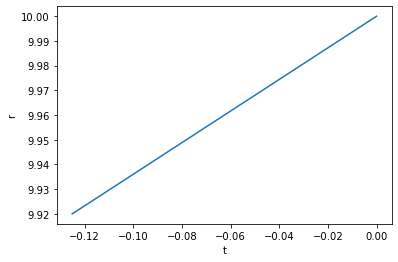

In [142]:
N = 1000
delta = 1e-4
omega = 1
q0 = [0,10,pi/2,0]
p0 = [1,-1,1,0]
Param = [1.0,0.0]
order = 2

sol = geodesic_integrator(N,delta,omega,q0,p0,Param,order)

# Get the position and momentum of the particle in the first phase space
sol = np.array(sol[1:])
qs = sol[:,0,:]
ps = sol[:,1,:]

ts, rs, thetas, phis = qs[:,0], qs[:,1], qs[:,2], qs[:,3]

plt.plot(qs[:,0],qs[:,1])
plt.xlabel("t")
plt.ylabel("r")

plt.show()

### Functions to calculate tensors

In [143]:
def metric_tensor():
    
    M, a = sp.symbols('M a', real=True)
    t, r, theta, phi = sp.symbols('t r theta phi', real=True)
    # r = sp.Function('r', real=True)(t)
    # theta = sp.Function('theta', real=True)(t)
    # phi = sp.Function('phi', real=True)(t)

    # Metric components of Kerr black hole
    
    Sigma = r**2 + a**2 * sp.cos(theta)**2
    Delta = r**2 - 2*M*r + a**2
    
    # There is an issue with the bellow kerr metric somewhere, gamma[1,2,2] is wrong, so likely sign error or something
    # g01, g02, g10, g12, g13, g20, g21, g23, g31, g32 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    # g00 = -(1 - 2*M*r/Sigma)
    # g11 = Sigma / Delta
    # g22 = Sigma / Delta
    # g33 = (r**2 + a**2 + 2*M*r*a**2 * sp.sin(theta)**2 / Sigma) * sp.sin(theta)**2
    # g03 = -2*M*r*a*sp.sin(theta)**2 / Sigma
    # g30 = g03
    
    # Use Schwarzschild metric for now
    g00 = -(1-2*M/r)
    g11 = 1/(1-2*M/r)
    g22 = r**2
    g33 = r**2 * sp.sin(theta)**2
    g01 = g02 = g03 = g10 = g12 = g13 = g20 = g21 = g23 = g30 = g31 = g32 = 0

    # Full metric
    g_metric = sp.Matrix([
        [g00, g01, g02, g03],
        [g10, g11, g12, g13],
        [g20, g21, g22, g23],
        [g30, g31, g32, g33]
    ])
    
    return g_metric

def calc_metric_derivs(g_metric, coords):
    M, a = sp.symbols('M a', real=True)
    t, r, theta, phi = sp.symbols('t r theta phi', real=True)
    coords = [t, r, theta, phi]
    N = len(coords)
    
    # g_derivs = sp.MutableDenseNDimArray(np.zeros((N, N, N)))
    g_derivs = [[[0 for k in range(N)] for j in range(N)] for i in range(N)]
    for i in range(N):
        for j in range(N):
            for k in range(N):
                g_derivs[i][j][k] = g_metric[i,j].diff(coords[k])
    return g_derivs

def compute_christoffel_Kerr(M_val, a_val, t_val, r_val, theta_val, phi_val):

    M, a = sp.symbols('M a', real=True)
    t, r, theta, phi = sp.symbols('t r theta phi', real=True)
    coords = [t, r, theta, phi]
    N = len(coords)
    
    g_metric = metric_tensor()
    g_derivs = calc_metric_derivs(g_metric, coords)

    # Specify the modules to be used in lambdify
    modules = [{"cos": np.cos, "sin": np.sin}, "numpy"]

    # Make metric and metric partial derivatives callable as a numerical function
    g_numeric = sp.lambdify((M, a, t, r, theta, phi), g_metric, "numpy")
    g_num = np.array(g_numeric(M_val, a_val, t_val, r_val, theta_val, phi_val))
    g_derivs_numeric = sp.lambdify((M, a, t, r, theta, phi), g_derivs, "numpy")
    g_derivs_num = np.array(g_derivs_numeric(M_val, a_val, t_val, r_val, theta_val, phi_val))
    
    # Numerically compute the inverse of the evaluated metric tensor
    g_inv_num = np.linalg.inv(g_num)
    
    # Compute the Christoffel symbols using the numerical inverse metric
    Gamma_num = np.zeros((N, N, N))
    for i in range(4):
        for j in range(4):
            for k in range(4):
                if j <= k:  # Use the symmetry of the Christoffel symbols
                    Gamma_num[i, j, k] = 0.5 * sum([g_inv_num[i, l] * 
                                                   (g_derivs_num[l, j, k] + 
                                                    g_derivs_num[l, k, j] -
                                                    g_derivs_num[j, k, l]) for l in range(4)])
                    Gamma_num[i, k, j] = Gamma_num[i, j, k]
                    
    return Gamma_num


In [229]:
def compute_partial_christoffel(M_val, a_val, t_val, r_val, theta_val, phi_val, delta=1e-3):

    
    # Store the parameters in a list for easier access
    params = [M_val, a_val, t_val, r_val, theta_val, phi_val]
    # coords = [t_val, x_val, y_val, z_val], t_val has index 0 in params, x_val has index 5 in params etc.
    coord_index = [2, 3, 4, 5]  # The indices of the coordinates in the params list
    index_map = {2: 0, 3: 1, 4: 2, 5: 3}  # Map the coordinate index to the index of the partial derivative
    
    # Calculate the base Christoffel symbols
    base_Gamma = compute_christoffel_Kerr(*params)
    
    # Initialize the array to store the derivatives
    partials = np.zeros((4, 4, 4, 4))
    
    # Loop over the parameters and compute the Christoffel symbols for a small perturbation in each parameter
    for i, param in enumerate(params):
        # Create a copy of the parameters and perturb the i-th parameter, if it is a coordinate
        if i in coord_index:
            # Use two point finite difference scheme for coordinates
            perturbed_params_adv = params.copy()  # Perturbed parameters for forward difference
            perturbed_params_ret = params.copy()  # Perturbed parameters for backward difference
            perturbed_params_adv[i] += delta
            perturbed_params_ret[i] -= delta
            
            # Compute the perturbed Christoffel symbols
            perturbed_Gamma_adv = compute_christoffel_Kerr(*perturbed_params_adv)
            perturbed_Gamma_ret = compute_christoffel_Kerr(*perturbed_params_ret)
            
            # Compute the partial derivative using two stencil finite difference scheme - O(h**2)
            partials[:, :, :, index_map[i]] = (perturbed_Gamma_adv - perturbed_Gamma_ret) / (2*delta)
        
    return partials
  
def compute_riemann_tensor(gammas, partial_gammas, g_inv):

    riemann = np.zeros((4, 4, 4, 4))
    for alpha in range(4):
      for beta in range(4):
          for gamma in range(4):
              for delta in range(4):
                  riemann[alpha, beta, gamma, delta] = (
                      partial_gammas[alpha, beta, delta, gamma] - 
                      partial_gammas[alpha, beta, gamma, delta]
                  )
                  
                  for nu in range(4):
                      riemann[alpha, beta, gamma, delta] += (
                          gammas[nu, beta, delta] * gammas[alpha, nu, gamma] -
                          gammas[nu, beta, gamma] * gammas[alpha, nu, delta]
                      )
    
    return riemann

def compute_ricci_tensor(riemann):
    # ricci = np.zeros((4, 4))
    # for mu in range(4):
    #     for nu in range(4):
    #         ricci[mu, nu] = sum([riemann[alpha, mu, alpha, nu] for alpha in range(4)])
    
    return np.einsum('rarb->ab', riemann)

def compute_ricci_scalar(ricci_tensor, g_inv):

    return np.einsum('ab,ab', g_inv, ricci_tensor)

def compute_kretschmann(riemann_tensor, g_inv):
    # Riemann = R^a_{bcd}, K = R^{abcd}R_{abcd} = R^a_{bcd}R_a^{bcd} = R^a_{bcd} g_{ae} g^{bf} g^{cg} g^{dh} R^e_{fgh}
    g_metric = np.linalg.inv(g_inv)
    return np.einsum('abcd,ae,bf,cg,dh,efgh', riemann_tensor, g_metric, g_inv, g_inv, g_inv, riemann_tensor)

def compute_landau_lifshitz(Gamma, g_inv, delta=1e-5):
    """
    Compute the Landau-Lifshitz pseudotensor using the affine formulation.
    
    Parameters:
    - Gamma: Christoffel symbols.
    - g_inv: Inverse metric tensor.
    
    Returns:
    - A 4x4 numpy array corresponding to the Landau-Lifshitz pseudotensor.
    """
    
    t = np.zeros((4, 4))
    
    for i in range(4):
        for k in range(4):
            for l in range(4):
                for m in range(4):
                    for n in range(4):
                        for p in range(4):
                            t[i, k] += ((g_inv[i, l] * g_inv[k, m] - g_inv[i,k] * g_inv[l,m])* (2 * Gamma[n, l, m] * Gamma[p, n, p] - Gamma[n, l, p] * Gamma[p, m, n] - Gamma[n, l, n] * Gamma[p, m, p]) +
                                        g_inv[i, l] * g_inv[m, n] * (Gamma[k, l, p] * Gamma[p, m, n] + Gamma[k, m, n] * Gamma[p, l, p] - Gamma[k, n, p] * Gamma[p, l, m] - Gamma[k, l, m] * Gamma[p, n, p]) +
                                        g_inv[k, l] * g_inv[m, n] * (Gamma[i, l, p] * Gamma[p, m, n] + Gamma[i, m, n] * Gamma[p, l, p] - Gamma[i, n, p] * Gamma[p, l, m] - Gamma[i, l, m] * Gamma[p, n, p]) +
                                        g_inv[l, m] * g_inv[n, p] * (Gamma[i, l, n] * Gamma[k, m, p] - Gamma[i, l, m] * Gamma[k, n, p]))
    
    # g_metric = np.linalg.inv(g_inv)
    # g = np.linalg.det(g_metric)
    
    # t = -g * (np.einsum('mn,ab->mnab', g_inv, g_inv) - np.einsum('ma,nb->mnab', g_inv, g_inv))
    
    # t *= 1 / (16 * np.pi * -g)
    # term1 = 2*np.einsum('sab,rsr,ma,nb->mn', Gamma, Gamma, g_inv, g_inv) - 2*np.einsum('sab,rsr,mn,ab->mn', Gamma, Gamma, g_inv, g_inv)
    # term2 = -np.einsum('sar,rbs,ma,nb->mn', Gamma, Gamma, g_inv, g_inv) + np.einsum('sar,rbs,mn,ab->mn', Gamma, Gamma, g_inv, g_inv)
    # term3 = -np.einsum('sas,rbr,ma,nb->mn', Gamma, Gamma, g_inv, g_inv) + np.einsum('sas,rbr,mn,ab->mn', Gamma, Gamma, g_inv, g_inv)
    
    # term4 = np.einsum('nar,rbs,ma,bs->mn', Gamma, Gamma, g_inv, g_inv)
    # term5 = np.einsum('nbs,rar,ma,bs->mn', Gamma, Gamma, g_inv, g_inv)
    # term6 = -np.einsum('nsr,rab,ma,bs->mn', Gamma, Gamma, g_inv, g_inv)
    # term7 = -np.einsum('nab,rsr,ma,bs->mn', Gamma, Gamma, g_inv, g_inv)
    
    # term8 = np.einsum('mar,rbs,na,bs->mn', Gamma, Gamma, g_inv, g_inv)
    # term9 = np.einsum('mbs,rar,na,bs->mn', Gamma, Gamma, g_inv, g_inv)
    # term10 = -np.einsum('msr,rab,na,bs->mn', Gamma, Gamma, g_inv, g_inv)
    # term11 = -np.einsum('mab,rsr,na,bs->mn', Gamma, Gamma, g_inv, g_inv)
    
    # term12 = np.einsum('mas,nbr,ab,sr->mn', Gamma, Gamma, g_inv, g_inv) - np.einsum('mab,nsr,ab,sr->mn', Gamma, Gamma, g_inv, g_inv)
    
    # print(t)
    
    # print(1 / (16 * np.pi) * (term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8 + term9 + term10 + term11 + term12))
    
    return t

In [224]:
def calculate_tensors(parameters):
    
    M, a, t, r, theta, phi = sp.symbols('M a t r theta phi', real=True)
    coords = [t, r, theta, phi]
    
    M_val, a_val, t_val, r_val, theta_val, phi_val = parameters
    test_values = (M_val, a_val, t_val, r_val, theta_val, phi_val)
    
    g_metric = metric_tensor()
    g_derivs = calc_metric_derivs(g_metric, coords)
    # Specify the modules to be used in lambdify
    modules = [{"cos": np.cos, "sin": np.sin}, "numpy"]

    # Make metric and metric partial derivatives callable as a numerical function
    g_numeric = sp.lambdify((M, a, t, r, theta, phi), g_metric, "numpy")
    g_num = g_numeric(M_val, a_val, t_val, r_val, theta_val, phi_val)
    g_derivs_numeric = sp.lambdify((M, a, t, r, theta, phi), g_derivs, "numpy")
    g_derivs_num = np.array(g_derivs_numeric(M_val, a_val, t_val, r_val, theta_val, phi_val))
    
    g_metric = g_numeric(*test_values)
    g_inv = np.linalg.inv(g_metric)
    Gamma = compute_christoffel_Kerr(*test_values)
    Gamma_partials = compute_partial_christoffel(*test_values)

    riemann_tensor = compute_riemann_tensor(Gamma, Gamma_partials, g_inv)
    ricci_tensor = compute_ricci_tensor(riemann_tensor)
    ricci_scalar = compute_ricci_scalar(ricci_tensor, g_inv)

    K = compute_kretschmann(riemann_tensor, g_inv)
    
    t = compute_landau_lifshitz(Gamma, g_inv)
    
    return g_metric, g_inv, Gamma, Gamma_partials, riemann_tensor, ricci_tensor, ricci_scalar, K, t

def evaluate_scalars(param_array):
    """Calculate a list of Kretschmann scalars and Ricci scalars for a given array of parameters.

    Args:
        param_array (list): List contaning all parameters at each timestep

    Returns:
        Ks: List of Krechsmann scalars
        Rs: List of Ricci scalars
    """
    Ks = []
    Rs = []

    for i in range(1, len(param_array)):
        
        m_val, a_val, t_val, r_val, theta_val, phi_val = param_array[i]
        test_values = (m_val, a_val, t_val, r_val, theta_val, phi_val)
        
        g_metric, g_inv, Gamma, Gamma_partials, riemann_tensor, ricci_tensor_test, ricci_scalar_test, K_test = calculate_tensors(test_values)
        
        Rs.append(ricci_scalar_test)
        Ks.append(K_test)
    
    return Ks, Rs

def plot_scalars(param_array, save_fig=False):
    Ks, Rs = evaluate_scalars(param_array)
    
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    

    data1 = Ks
    data2 = Rs
    t = np.array(param_array)[1:,0]

    fig, ax1 = plt.subplots()
    color = 'red'

    ax1.set_xlabel('Time')
    ax1.set_ylabel('K', color=color)
    ax1.plot(t, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()

    color = 'blue'
    ax2.set_ylabel('R', color=color)
    ax2.plot(t, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title("Ricci scalar and Kretchsmenn scalar over simulation")

    plt.show()

### Test with a given value

In [227]:
t_val = 0
m_val = 0.5
r_val, theta_val, phi_val = 10, np.pi/2, 0
a_val = 0
test_values = (m_val, a_val, t_val, r_val, theta_val, phi_val)
g_metric, g_inv, Gamma, Gamma_partials, riemann_tensor, ricci_tensor_test, ricci_scalar_test, K_test, t_test = calculate_tensors(test_values)

In [235]:
g_metric

array([[ -0.9       ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   1.11111111,   0.        ,   0.        ],
       [  0.        ,   0.        , 100.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , 100.        ]])

### Test Gamma coefficients match

Compare values with formula for Schwarzschild Christofell symbols

In [234]:
# Test christoffel symbols against known values
print(Gamma[1,0,0] - m_val*(r_val-2*m_val)/r_val**3)
print(Gamma[1,1,1] + m_val/(r_val*(r_val-2*m_val)))
print(Gamma[1,2,2] + (r_val-2*m_val))   #Error with gamma^r_{\theta \theta}
print(Gamma[1,3,3] + (r_val-2*m_val)*np.sin(theta_val)**2)
print(Gamma[0,1,0] - m_val/(r_val*(r_val-2*m_val)))
print(Gamma[2,1,2] - 1/r_val)   #Error with gamma^theta_{\r \theta}
print(Gamma[2,3,3] + np.sin(theta_val)*np.cos(theta_val))
print(Gamma[3,1,3] - 1/r_val)
print(Gamma[3,2,3] - np.cos(theta_val)/np.sin(theta_val))


print("Components:")
print(Gamma[1,0,0], m_val*(r_val-2*m_val)/r_val**3)
print(Gamma[1,1,1], m_val/(r_val*(r_val-2*m_val)))
print(Gamma[1,2,2], (r_val-2*m_val))   #Error with gamma^r_{\theta \theta}
print(Gamma[1,3,3], (r_val-2*m_val)*np.sin(theta_val)**2)
print(Gamma[0,1,0], m_val/(r_val*(r_val-2*m_val)))
print(Gamma[2,1,2], 1/r_val)   #Error with gamma^theta_{\r \theta}
print(Gamma[2,3,3], np.sin(theta_val)*np.cos(theta_val))
print(Gamma[3,1,3], 1/r_val)
print(Gamma[3,2,3], np.cos(theta_val)/np.sin(theta_val))



0.0
8.673617379884035e-19
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Components:
0.0045 0.0045
-0.005555555555555555 0.005555555555555556
-9.0 9.0
-9.0 9.0
0.005555555555555556 0.005555555555555556
0.1 0.1
-6.123233995736766e-17 6.123233995736766e-17
0.1 0.1
6.123233995736766e-17 6.123233995736766e-17


So Christoffel symbols match

### Check partial derivatives of Christoffel symbols

See mathematica notebook "schwarzschild_symbols.nb"

In [148]:
# Test christoffel partial derivatives

print(Gamma_partials[0,0,1,1], 2*m_val*(m_val-r_val)/(r_val**2*(r_val-2*m_val)**2))
print(Gamma_partials[1,0,0,1], 2*m_val*(3*m_val-r_val)/(r_val**4))
print(Gamma_partials[1,1,1,1], 2*m_val*(-m_val+r_val)/(r_val**2*(r_val-2*m_val)**2))
print(Gamma_partials[1,2,2,1], -1)
print(Gamma_partials[1,3,3,1], -np.sin(theta_val)**2)

print(Gamma_partials[1,2,1,2], -1/r_val**2)
print(Gamma_partials[2,2,1,1], -1/r_val**2)
print(Gamma_partials[3,1,3,1], -1/r_val**2)
print(Gamma_partials[3,3,1,1], -1/r_val**2)

print(Gamma_partials[1,3,3,2], (2*m_val-r_val)*np.sin(2*theta_val))
print(Gamma_partials[2,3,3,2], -np.cos(2*theta_val))
print(Gamma_partials[3,2,3,2], -1/np.sin(theta_val))


-0.001172839532379618 -0.0011728395061728395
-0.0008500000149994427 -0.00085
0.0011728395323804854 0.0011728395061728395
-0.9999999999994458 -1
-0.9999999999994458 -1.0
0.0 -0.01
-0.010000000099992523 -0.01
-0.010000000099992523 -0.01
-0.010000000099992523 -0.01
0.0 -1.102182119232618e-15
0.9999993333333564 1.0
-1.0000003333333563 -1.0


So Gamma partial derivatives match

### Check Riemann tensor

In [149]:
# Just check a couple of values
print(riemann_tensor[0,1,0,1], -riemann_tensor[0,1,1,0], 2*m_val/(r_val**2*(r_val-2*m_val)))
print(riemann_tensor[0,2,0,2], riemann_tensor[1,2,1,2], -riemann_tensor[0,2,2,0], -riemann_tensor[1,2,2,1], -m_val/r_val)
print(riemann_tensor[3,2,2,3], -riemann_tensor[3,2,3,2], -2*m_val/r_val)


0.0011111111373178894 0.0011111111373178894 0.0011111111111111111
-0.05 -0.04999999999944571 -0.05 -0.04999999999944571 -0.05
-0.10000033333335623 -0.10000033333335623 -0.1


Looks pretty good.

Now, since Schwwarzschild is a solution to Einstein's field equations, the Ricci tensor (and ricci scalar) should have all components zero. Let's check this

Largest component is O(10^-7), so there's either a problem with the formula or a fair amount of error.

##### Let's now check that the Kretchsmen scalar behaves as expected

In [151]:
print(K_test, 48*m_val**2/r_val**6) # Works at a single point, let's check it continues to hold

1.1999986467792995e-05 1.2e-05


'On iteration number 0 with delta 0.01'

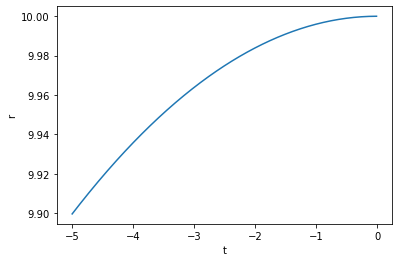

In [152]:
N = 400
delta = 1e-2
omega = 1
q0 = [0,10,np.pi/2,0]
p0 = [1,0,0.0,0]
Param = [1.0,0.0]
order = 4

sol = geodesic_integrator(N,delta,omega,q0,p0,Param,order)

# Get the position and momentum of the particle in the first phase space
sol = np.array(sol[1:])
qs = sol[:,0,:]
ps = sol[:,1,:]

ts, rs, thetas, phis = qs[:,0], qs[:,1], qs[:,2], qs[:,3]

plt.plot(qs[:,0],qs[:,1])
plt.xlabel("t")
plt.ylabel("r")

plt.show()

In [153]:
Ms = 1
spins = 0.0

param_storage_new = []

for index in range(len(ts)):
    t = ts[index]
    r = rs[index]
    theta = thetas[index]
    phi = phis[index]
    
    params = [Ms, spins, t, r, theta, phi]
    
    param_storage_new += [params]

In [154]:
Ks_new, Rs_new = evaluate_scalars(param_storage_new)

Text(0.5, 1.0, 'Comparing Kretschmann scalar to known value')

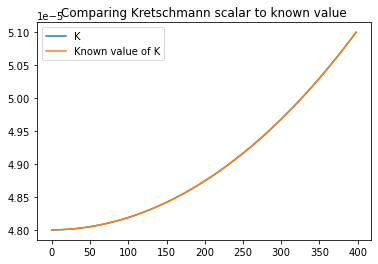

In [162]:
plt.plot(Ks_new, label="K")
plt.plot(48*Ms**2/rs[1::]**6, label="Known value of K")
plt.legend()
plt.title("Comparing Kretschmann scalar to known value")

'On iteration number 3000 with delta 0.01'

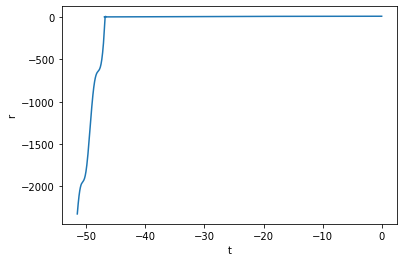

In [170]:
N = 3500
delta = 1e-2
omega = 1
q0 = [0,10,np.pi/2,0]
p0 = [1,0,0.0,0]
Param = [1.0,0.0]
order = 2

sol = geodesic_integrator(N,delta,omega,q0,p0,Param,order)

# Get the position and momentum of the particle in the first phase space
sol = np.array(sol[1:])
qs = sol[:,0,:]
ps = sol[:,1,:]

ts, rs, thetas, phis = qs[:,0], qs[:,1], qs[:,2], qs[:,3]

plt.plot(qs[:,0],qs[:,1])
plt.xlabel("t")
plt.ylabel("r")

plt.show()

In [173]:
Ms = 1
spins = 0.0

param_storage_new = []

for index in range(0,len(ts),100):
    t = ts[index]
    r = rs[index]
    theta = thetas[index]
    phi = phis[index]
    
    params = [Ms, spins, t, r, theta, phi]
    
    param_storage_new += [params]

In [174]:
Ks_new, Rs_new = evaluate_scalars(param_storage_new)

In [190]:
rs[::100].shape

(3495,)

Text(0.5, 1.0, 'Comparing Kretschmann scalar to known value')

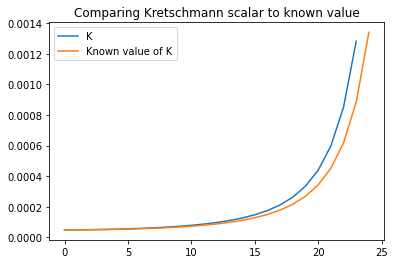

In [195]:
rs = rs[1:-1000]
plt.plot(Ks_new[:-10], label="K")
plt.plot(48*Ms**2/rs[::100]**6, label="Known value of K")
plt.legend()
plt.title("Comparing Kretschmann scalar to known value")

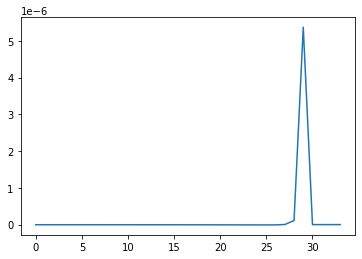

In [197]:
plt.plot(Rs_new[:], label="R")

### Check Landau-Liftschitz pseudo tensor

In [233]:

print(t_test[0,0],2*(5*r_val-12*m_val+r_val/np.tan(theta_val)**2)/(r_val**2 * (r_val-2*m_val)))
print(t_test[1,1], -2*(r_val-2*m_val)*(1/np.tan(theta_val)**2 - 1)/r_val**3)
print(t_test[1,2], t_test[2,1], 2*(r_val-2*m_val)/(r_val**4 * np.tan(theta_val)))
print(t_test[2,2], -2/r_val**4)
print(t_test[3,3], -2/(np.sin(theta_val)**2 * r_val**4))

-0.0977777777777778 0.09777777777777778
-0.017999999999999995 0.018
-2.32682891837997e-19 -2.326828918379971e-19 1.1021821192326178e-19
0.00019999999999999993 -0.0002
0.00019999999999999993 -0.0002


Components are all the negatives of the correct answer, except t^{12}=t^{21} which is off. But the compnent is so small it could just be numerical error